In [65]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [66]:
!nvidia-smi

Thu Sep  3 15:20:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:37:00.0 Off |                  Off |
| 31%   43C    P2    36W / 250W |   6446MiB / 32508MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

bur_vol_loss        0.365880
loss                0.060580
spin_loss           0.023966
val_bur_vol_loss    0.398604
val_loss            0.072824
val_spin_loss       0.031998
dtype: float64


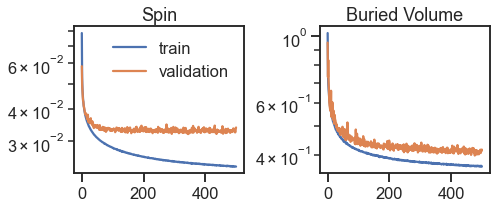

In [98]:
fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(7, 3))

log1 = pd.read_csv('20200901_combined_losses/log.csv').set_index('epoch')

axs[0].plot(log1['spin_loss'], label='train')
axs[0].plot(log1['val_spin_loss'], label='validation')
axs[0].set_title('Spin')

axs[1].plot(log1['bur_vol_loss'])
axs[1].plot(log1['val_bur_vol_loss'])
axs[1].set_title('Buried Volume')

for ax in axs:
    ax.set_yscale('log')
    
print(log1.min())
axs[0].legend()

plt.tight_layout()
# plt.xlim([0, 10])

In [99]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [101]:
from preprocess_inputs import preprocessor
preprocessor.from_json('tfrecords/preprocessor.json')

from loss import AtomInfMask, KLWithLogits
from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate

model = tf.keras.models.load_model(
    '20200901_combined_losses/best_model.hdf5',
    custom_objects={**nfp.custom_objects,
                    **{'AtomInfMask': AtomInfMask, 'KLWithLogits': KLWithLogits,
                       'EdgeUpdate': EdgeUpdate,
                       'NodeUpdate': NodeUpdate,
                       'GlobalUpdate': GlobalUpdate}})

In [108]:
cdf_spin = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/cdf_spins.csv.gz')
cdf_bv = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/cdf_buried_volume.csv.gz', index_col=0)
cdf = cdf_spin.merge(cdf_bv, on=['smiles', 'atom_index'], how='left')

test = np.load('split.npz', allow_pickle=True)['test']

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [109]:
cdf_test = cdf[cdf.smiles.isin(test)].copy()
cdf_test['fractional_spin'] = cdf_test.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

atom_index,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
smiles,,,,,,,,,,,,,,,,,,,,,
CO/[C]=C1/CCCCC1=O,0.001776,0.103081,0.702058,0.109981,0.001902,0.002830,0.001808,0.005006,0.042844,0.010367,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C[CH]C[C@@H]1COOO1,0.047013,0.718680,0.057055,0.019739,0.001834,0.000174,0.000294,0.000185,0.005816,0.043117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC[C@@H](F)C(=[N])N,0.000306,0.000109,0.074523,0.005681,0.122172,0.762786,0.020510,0.000498,0.000044,0.000007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[CH2]Nc1ccc(C)c(Cl)c1,0.597656,0.083265,0.045439,0.047257,0.023602,0.053582,0.002519,0.020194,0.000900,0.065124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NCc1nc[c]cc1F,0.000266,0.004885,0.036233,0.059242,0.046752,0.721763,0.058991,0.046018,0.003389,0.000182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
redf_spin = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/redf_spins.csv.gz')
redf_bv = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/redf_buried_volume.csv.gz')
redf = redf_spin.merge(redf_bv, on=['smiles', 'atom_index', 'atom_type'], how='left')
redf['fractional_spin'] = redf.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

redf_test = np.load('redf_split.npz', allow_pickle=True)['test']
redf_smiles = redf.smiles.unique()

In [148]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in test),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_atoms=cdf_test.atom_index.max() + 1),
                  padding_values=preprocessor.padding_values)

In [149]:
redf_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in redf.smiles.unique()),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_atoms=redf.atom_index.max() + 1),
                  padding_values=preprocessor.padding_values)

In [150]:
predicted_spin_logits, predicted_bur_vol = model.predict(test_dataset, verbose=1)
predicted_fractional_spins = tf.nn.softmax(predicted_spin_logits)

     16/Unknown - 2s 104ms/step

RDKit WARNING: [07:04:40] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [07:04:40]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [07:04:41] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [07:04:41]   BondStereo set to STEREONONE and single bond directions set to NONE.


40/40 [==============================] - 4s 102ms/step


Text(0.5, 1.0, 'Buried Volume')

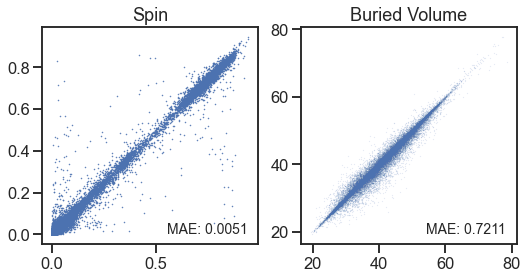

In [246]:
cdf_test_pivot_spins = cdf_test.pivot(index='smiles', columns='atom_index', values='fractional_spin')
cdf_test_pivot_spins = cdf_test_pivot_spins.reindex(test)

cdf_test_pivot_bur_vol = cdf_test.pivot(index='smiles', columns='atom_index', values='buried_vol')
cdf_test_pivot_bur_vol = cdf_test_pivot_bur_vol.reindex(test)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5,4))
axs[0].plot(cdf_test_pivot_spins.values.flatten(), predicted_fractional_spins.numpy().flatten(), '.', ms=1)
axs[0].text(.95, .05, f'MAE: {pd.Series(cdf_test_pivot_spins.values.flatten() - predicted_fractional_spins.numpy().flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[0].transAxes, fontsize=14)

axs[1].plot(cdf_test_pivot_bur_vol.values.flatten(), predicted_bur_vol.flatten(), '.', ms=.1)
axs[1].text(.95, .05, f'MAE: {pd.Series(cdf_test_pivot_bur_vol.values.flatten() - predicted_bur_vol.flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[1].transAxes, fontsize=14)

axs[0].set_title('Spin')
axs[1].set_title('Buried Volume')

In [183]:
rpredicted_spin_logits, rpredicted_bur_vol = model.predict(redf_dataset, verbose=1)
rpredicted_fractional_spins = tf.nn.softmax(rpredicted_spin_logits)

     54/Unknown - 5s 97ms/step

RDKit WARNING: [07:12:04] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [07:12:04]   BondStereo set to STEREONONE and single bond directions set to NONE.


    107/Unknown - 11s 100ms/step

RDKit WARNING: [07:12:10] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [07:12:10]   BondStereo set to STEREONONE and single bond directions set to NONE.


115/115 [==============================] - 11s 99ms/step


Text(0.5, 1.0, 'Buried Volume')

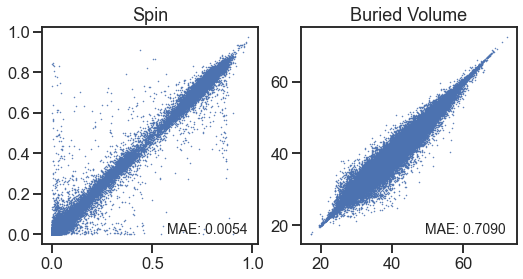

In [189]:
redf_pivot_spins = redf.pivot(index='smiles', columns='atom_index', values='fractional_spin')
redf_pivot_spins = redf_pivot_spins.reindex(redf_smiles)

redf_pivot_bur_vol = redf.pivot(index='smiles', columns='atom_index', values='bur_vol')
redf_pivot_bur_vol = redf_pivot_bur_vol.reindex(redf_smiles)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5,4))
axs[0].plot(redf_pivot_spins.values.flatten(), rpredicted_fractional_spins.numpy().flatten(), '.', ms=1)
axs[0].text(.95, .05, f'MAE: {pd.Series(redf_pivot_spins.values.flatten() - rpredicted_fractional_spins.numpy().flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[0].transAxes, fontsize=14)

axs[1].plot(redf_pivot_bur_vol.values.flatten(), rpredicted_bur_vol.flatten(), '.', ms=1)
axs[1].text(.95, .05, f'MAE: {pd.Series(redf_pivot_bur_vol.values.flatten() - rpredicted_bur_vol.flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[1].transAxes, fontsize=14)

axs[0].set_title('Spin')
axs[1].set_title('Buried Volume')

In [266]:
bur_vol_err = cdf_test_pivot_bur_vol - predicted_bur_vol.squeeze()
bur_vol_err = bur_vol_err.abs().reset_index().melt(id_vars=['smiles']).dropna()

In [271]:
bur_vol_pred = pd.DataFrame(predicted_bur_vol.squeeze(), index=cdf_test_pivot_bur_vol.index, columns=cdf_test_pivot_bur_vol.columns)
bur_vol_pred = bur_vol_pred.abs().reset_index().melt(id_vars=['smiles']).dropna()

In [277]:
bur_vol_err_df = bur_vol_err.merge(
    bur_vol_pred, how='left', on=['smiles', 'atom_index'], suffixes=('_err', '_pred')).merge(
    cdf_test[['smiles', 'atom_index', 'buried_vol']], on=['smiles', 'atom_index'])

In [282]:
bur_vol_err_df.sort_values('value_err', ascending=False).head(10).iloc[1].smiles

'[CH]=C1[C@H]2C[C@@H](C(C)(C)O[C@H]3O[C@H](CO)[C@@H](O)C(=O)[C@@H]3O)CC[C@]2(C)C[C@H](O)[C@@H]1O'

In [284]:
import rdkit.Chem
def num_atoms(smiles):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    return mol.GetNumAtoms()

In [289]:
from tqdm import tqdm
tqdm.pandas()

bur_vol_err_df['num_atoms'] = bur_vol_err_df.smiles.progress_apply(num_atoms)

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 1/43138 [00:00<3:27:00,  3.47it/s]RDKit WARNING: [08:21:30] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [08:21:30]   BondStereo set to STEREONONE and single bond directions set to NONE.
  4%|▍         | 1760/43138 [00:00<2:19:00,  4.96it/s]RDKit WARNING: [08:21:30] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [08:21:30]   BondStereo set to STEREONONE and single bond directions set to NONE.
 12%|█▏        | 5342/43138 [00:00<1:02:14, 10.12it/s]RDKit WARNING: [08:21:30] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [08:21:30]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [08:21:

In [293]:
bur_vol_err_df[bur_vol_err_df.num_atoms > 20].value_err.mean()

1.345533972832391

Text(0.5, 1.0, '>20 atoms')

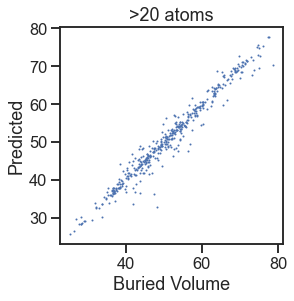

In [296]:
plt.figure(figsize=(4,4))
plt.plot(bur_vol_err_df[bur_vol_err_df.num_atoms > 20].buried_vol, bur_vol_err_df[bur_vol_err_df.num_atoms > 20].value_pred, '.', ms=2)
plt.xlabel('Buried Volume')
plt.ylabel('Predicted')
plt.title('>20 atoms')

In [306]:
smiles = bur_vol_err_df[bur_vol_err_df.num_atoms <= 10].sort_values('value_err', ascending=False).head(6).smiles

['OCC[CH]/C=C\\CCCO',
 '[CH2]S/C=C\\C(=O)N1CCC1',
 'C[C@H]([O])CN(C)CCO',
 'N=C(N)SC[CH]S(=O)(=O)O',
 'CN(C)CCOP([O])(=O)O',
 '[NH]CCCCNCCCO']

In [311]:
import psycopg2

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'bdeops',
    'password': 'BD30ps99!',
    'options': f'-c search_path=bde',
}

with psycopg2.connect(**dbparams) as conn:

    cdf = pd.read_sql_query("""
    SELECT * from unique_compound where status='finished' and smiles in %s;
    """, conn, params=[tuple(smiles.values.tolist())])    

In [314]:
import shutil

In [318]:
import os

In [325]:
cdf['logbase'] = cdf.logfile.apply(os.path.basename)

In [326]:
cdf[['smiles', 'logbase']]

,smiles,logbase
0,C[C@H]([O])CN(C)CCO,99228_07bfe3.log.gz
1,[CH2]S/C=C\C(=O)N1CCC1,795386_5bc091.log.gz
2,CN(C)CCOP([O])(=O)O,879191_da9e6e.log.gz
3,N=C(N)SC[CH]S(=O)(=O)O,852794_6deda6.log.gz
4,[NH]CCCCNCCCO,118215_b1a809.log.gz
5,OCC[CH]/C=C\CCCO,194727_1f76d6.log.gz


In [322]:
for log in cdf.logfile:
    shutil.copy(log, '/home/pstjohn/Research/20200608_redox_calculations/bur_vol_logs/')